<a href="https://colab.research.google.com/github/vicmcl/deeplearwing/blob/main/deeplearwing/notebook/training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
import os
import glob

In [3]:
from google.colab import drive

drive.flush_and_unmount()
drive.mount('/content/drive')
DRIVE_PATH = Path("/content/drive/MyDrive/")
ML_PATH = DRIVE_PATH / "Projects" / "deeplearwing"

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


In [4]:
!git clone https://github.com/vicmcl/deeplearwing.git

Cloning into 'deeplearwing'...
remote: Enumerating objects: 184, done.
remote: Counting objects: 100% (134/134), done.
remote: Compressing objects: 100% (93/93), done.
remote: Total 184 (delta 61), reused 91 (delta 38), pack-reused 50
Receiving objects: 100% (184/184), 30.67 MiB | 13.77 MiB/s, done.
Resolving deltas: 100% (81/81), done.


In [5]:
DATASET = "victorienmichel/deeplearwing"
CONTENT_PATH = Path('/content')
PROJECT_PATH = CONTENT_PATH / 'deeplearwing'
DATA_PATH = PROJECT_PATH / 'data'
ZIP_FILE = DATASET.split('/')[-1].lower() + '.zip'

In [6]:
!cd {PROJECT_PATH} && git pull origin main
!cp -r {PROJECT_PATH / 'deeplearwing' / 'src'} {CONTENT_PATH}

From https://github.com/vicmcl/deeplearwing
 * branch            main       -> FETCH_HEAD
Already up to date.


In [7]:
if not os.path.exists(DATA_PATH):
    print(f'Creating {DATA_PATH}')
    os.makedirs(DATA_PATH)

if not glob.glob(str(DATA_PATH / '*.csv')):

    if not os.path.exists(PROJECT_PATH / ZIP_FILE):
        !kaggle datasets download -d {DATASET} -p {DATA_PATH}

    !unzip {DATA_PATH / ZIP_FILE} -d {DATA_PATH}
    !rm {DATA_PATH / ZIP_FILE}

Creating /content/deeplearwing/data
Dataset URL: https://www.kaggle.com/datasets/victorienmichel/deeplearwing
License(s): MIT
 87% 16.0M/18.3M [00:01<00:00, 17.3MB/s]
100% 18.3M/18.3M [00:01<00:00, 10.2MB/s]
Archive:  /content/deeplearwing/data/deeplearwing.zip
  inflating: /content/deeplearwing/data/DeepLearWing.csv  


In [8]:
!pip install -q aerosandbox

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.3/72.3 MB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.3/20.3 MB 27.7 MB/s eta 0:00:00


In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from src.features import string_to_floats
from src.plot import airfoil_to_image
from src.checkpoint import checkpoint

In [10]:
df_csv = pd.read_csv(DATA_PATH / 'DeepLearWing.csv')
df_csv.head()

,name,angle,reynolds,x_coords,y_coords,cd,cl,cm
0,2032c,-8.75,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.09761,-0.1581,-0.0262
1,2032c,-8.50,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.09468,-0.1536,-0.0262
2,2032c,-8.25,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.10671,-0.2407,-0.0219
3,2032c,-8.00,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.10247,-0.2303,-0.0213
4,2032c,-7.75,200000,1.0 0.95 0.9 0.8 0.7 0.6 0.5 0.4 0.3 0.25 0.2 ...,0.0016 0.0124 0.0229 0.0428 0.061 0.0771 0.090...,0.09947,-0.2229,-0.0215


In [11]:
n_samples = 10_000
samples = df_csv.sample(n = n_samples, random_state = 42)

In [12]:
mms = MinMaxScaler()
df = samples.copy()

In [13]:
targets = ['cd', 'cl', 'cm']
df.loc[:, 'cd'] = df['cd'].apply(np.log)
df.loc[:, targets] = mms.fit_transform(df[targets])
df['target'] = df.apply(lambda row: [row[t] for t in targets], axis = 1)
df = df.drop(columns = targets)

In [14]:
df[['angle', 'reynolds']] = mms.fit_transform(samples[['angle', 'reynolds']])
df.loc[:, ['x_coords', 'y_coords']] = df[['x_coords', 'y_coords']].applymap(string_to_floats)

In [15]:
df.head()

,name,angle,reynolds,x_coords,y_coords,target
51063,fx84w127,0.823899,0.157895,"[1.0, 0.99893, 0.99572, 0.99039, 0.98296, 0.97...","[0.0, 0.00011, 0.0005, 0.0012, 0.0023, 0.00385...","[0.6113299968184446, 0.760406247595599, 0.4372..."
802509,s8052,0.308176,0.052632,"[1.0, 0.99803, 0.99231, 0.98301, 0.97022, 0.95...","[0.0, 0.00018, 0.00079, 0.00181, 0.0033, 0.005...","[0.6177742953448339, 0.28383473109179047, 0.41..."
419227,goe505,0.301887,0.000000,"[1.0, 0.94959, 0.89918, 0.7985, 0.69791, 0.597...","[0.0, 0.01784, 0.03568, 0.06537, 0.09105, 0.10...","[0.8125685123506596, 0.34741350568079815, 0.46..."
132195,npl9660,0.735849,0.157895,"[1.0, 0.997614, 0.990418, 0.9785, 0.961985, 0....","[0.0013, 0.001763, 0.002031, 0.002194, 0.00332...","[0.44704191223458734, 0.7069067220640661, 0.49..."
542560,fx78k161,0.213836,0.473684,"[1.0, 0.99893, 0.99572, 0.99039, 0.98296, 0.97...","[0.0, 0.00103, 0.00172, 0.00262, 0.00365, 0.00...","[0.5093686478665304, 0.2525967530968685, 0.355..."


In [16]:
import concurrent.futures

with concurrent.futures.ThreadPoolExecutor() as executor:
    futures = [executor.submit(airfoil_to_image, row['x_coords'], row['y_coords'], 384, 128) for _, row in df.iterrows()]
    results = [future.result() for future in futures]

In [17]:
df['pixel_values'] = results
df = df.drop(columns = ['x_coords', 'y_coords'])

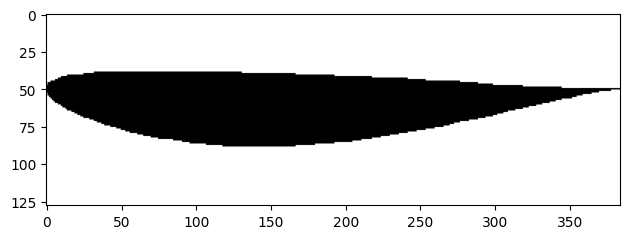

In [18]:
plt.imshow(results[0], cmap = 'gray')
plt.tight_layout()
plt.show()

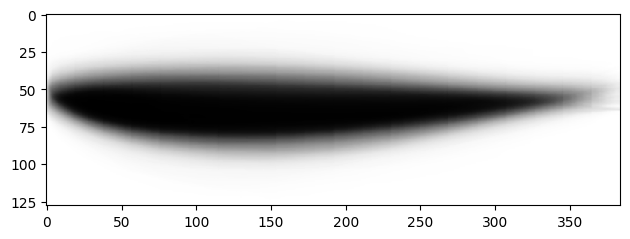

In [19]:
avg_airfoil = np.mean(df['pixel_values'], axis = 0)
plt.imshow(avg_airfoil, cmap='gray')
plt.tight_layout()

In [20]:
features = ['angle', 'reynolds', 'pixel_values']

X_train, X_test, y_train, y_test = train_test_split(
    df[features],
    df['target'],
    test_size = 0.2,
    random_state = 42,
    stratify = df[['reynolds']]
)

In [21]:
results[0].shape

(128, 384)

In [22]:
X_train.head()

,angle,reynolds,pixel_values
333607,0.364780,1.000000,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
159382,0.345912,0.157895,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
814009,0.635220,0.052632,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
626594,0.383648,0.473684,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."
428048,0.867925,0.000000,"[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,..."


In [23]:
X_train_CNN = np.expand_dims(np.array([x for x in X_train['pixel_values']]), axis = -1)
X_test_CNN = np.expand_dims(np.array([x for x in X_test['pixel_values']]), axis = -1)

X_train_ANN = np.array([x for x in np.column_stack((X_train['angle'], X_train['reynolds']))], dtype='float32')
X_test_ANN = np.array([x for x in np.column_stack((X_test['angle'], X_test['reynolds']))], dtype='float32')

In [24]:
y_train_array = np.array([x for x in y_train])
y_test_array = np.array([x for x in y_test])

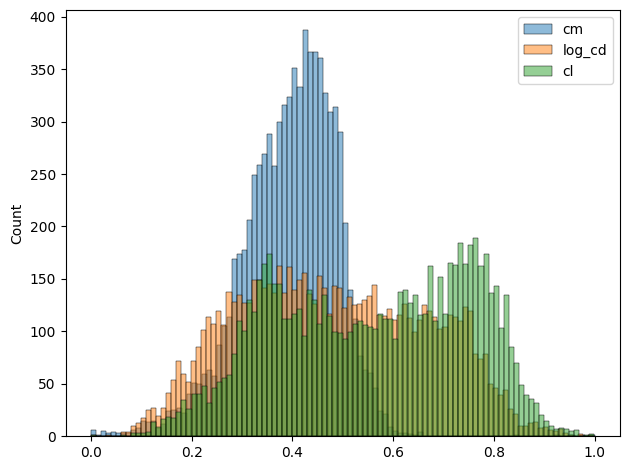

In [25]:
import seaborn as sns

sns.histplot(y_train_array[:, 2], label = 'cm', bins=100, alpha=0.5)
sns.histplot(y_train_array[:, 0], label = 'log_cd', bins=100, alpha=0.5)
sns.histplot(y_train_array[:, 1], label = 'cl', bins=100, alpha=0.5)
plt.legend()
plt.tight_layout()

In [32]:
from tensorflow.random import set_seed

from tensorflow.keras import backend, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    LeakyReLU,
    ReLU,
    Dense,
    Flatten,
    Dropout,
    BatchNormalization,
    Concatenate,
)

In [27]:
pip install -q keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.3 MB/s eta 0:00:00


In [28]:
def build_model(hp):

    normalization_conv = hp.Choice("Normalization_conv", ["yes", "no"])
    normalization_dense = hp.Choice("Normalization_dense", ["yes", "no"])

    dropout_conv = hp.Choice("dropout_conv", ["yes", "no"])
    dropout_dense = hp.Choice("dropout_dense", ["yes", "no"])

    rate_dropout_conv = hp.Float(
        "rate_dropout_conv", 0.1, 0.3, step = 0.1, default = 0.3
    )
    rate_dropout_dense = hp.Float(
        "rate_dropout_dense", 0.1, 0.3, step = 0.1, default = 0.3
    )

    # CNN branch
    cnn_input = Input(shape=(128, 384, 1))
    x = cnn_input

    for i in range(hp.Int("conv_layers", 2, 3)):
        x = Conv2D(
            filters=hp.Int(
                "filters_" + str(i),
                32,
                128,
                sampling = 'log',
                step = 2,
            ),
            kernel_size=hp.Int("kernel_size_" + str(i), 2, 4, step = 1),
            activation="relu",
            padding="same"
        )(x)

        x = MaxPooling2D()(x)

        if dropout_conv == "yes":
            x = Dropout(rate = rate_dropout_conv)(x)

        if normalization_conv == "yes":
            x = BatchNormalization()(x)

    cnn_output = Flatten()(x)

    # ANN branch
    ann_input = Input(shape=(2,))
    y = ann_input

    for i in range(hp.Int("dense_layers", 1, 3)):
        ann_output = Dense(
            units = hp.Int(
                "ann_neurons_" + str(i),
                32,
                128,
                sampling = 'log',
                step = 2,
            ),
            activation = "relu",
        )(y)

    # Combine the outputs
    combined_inputs = Concatenate()([cnn_output, ann_output])

    for i in range(hp.Int("dense_layers", 1, 3)):
        combined_output = Dense(
            units = hp.Int(
                "combined_neurons_" + str(i),
                32,
                128,
                sampling = 'log',
                step = 2,
            ),
            activation = "relu",
        )(combined_inputs)

        if dropout_dense == "yes":
            x = Dropout(rate=rate_dropout_dense)(x)

        if normalization_dense == "yes":
            x = BatchNormalization()(x)

    combined_output = Dense(units=3)(combined_output)

    # Create the model
    combined_model = Model(
        inputs = [cnn_input, ann_input],
        outputs = combined_output,
        name = "Combined_model"
    )


    # Compile the model
    combined_model.compile(
        loss="mse",
        optimizer=Adam(learning_rate=0.0005),
        metrics=['mae']
    )

    return combined_model

In [29]:
import keras_tuner as kt

tuner = kt.Hyperband(
    hypermodel = build_model,
    objective = "val_loss",
    max_epochs = 10,
    directory = PROJECT_PATH,
    project_name = "tuner",
    overwrite = True
)

tuner.search(
    [X_train_CNN, X_train_ANN],
    y_train_array,
    epochs = 10,
    batch_size = 32,
    shuffle = True,
    validation_split = 0.2,
)

best_model = tuner.get_best_models()[0]
best_model.summary()
best_model.save(ML_PATH / "best_model.keras")

Trial 30 Complete [00h 02m 15s]
val_loss: 0.03042782098054886

Best val_loss So Far: 0.00475543737411499
Total elapsed time: 00h 47m 16s
Model: "Combined_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 384, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 384, 32)         160       ['input_1[0][0]']             
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 64, 192, 32)          0         ['conv2d[0][0]']              
 D)                                                                                               
                                               

In [35]:
best_model = load_model(ML_PATH / "best_model.keras")
best_model.compile(
    loss="mse",
    optimizer=Adam(learning_rate=0.0005),
    metrics=['mae']
)

history = best_model.fit(
    [X_train_CNN, X_train_ANN],
    y_train_array,
    epochs = 100,
    batch_size = 32,
    callbacks=checkpoint(ML_PATH / f"weights_tuned_model.h5", patience = 3),
    validation_split = 0.2,
    shuffle = True,
    verbose = 1,
)

Epoch 1/100
200/200 [==============================] - 13s 56ms/step - loss: 0.0041 - mae: 0.0476 - val_loss: 0.0046 - val_mae: 0.0502
Epoch 2/100
  1/200 [..............................] - ETA: 8s - loss: 0.0029 - mae: 0.0408

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


200/200 [==============================] - 11s 53ms/step - loss: 0.0036 - mae: 0.0446 - val_loss: 0.0043 - val_mae: 0.0471
Epoch 3/100
200/200 [==============================] - 10s 52ms/step - loss: 0.0032 - mae: 0.0424 - val_loss: 0.0043 - val_mae: 0.0479
Epoch 4/100
200/200 [==============================] - 10s 52ms/step - loss: 0.0031 - mae: 0.0410 - val_loss: 0.0043 - val_mae: 0.0472
Epoch 5/100
200/200 [==============================] - 10s 51ms/step - loss: 0.0029 - mae: 0.0395 - val_loss: 0.0043 - val_mae: 0.0476
